## Part 2: Reverse optimization

Max Kapur | <a href="https://www.maxkapur.com/">maxkapur.com</a>

Given schools' cutoffs, which are percentile values indicating the worst student they will accept, and schools' capacities, as estimated from past enrollment, we try to determine the underlying MNL parameters $\delta_c$ that produce such a market at equilibrium. We assume that the total number of students in the market equals the total demand, or number of enrollees at all the schools.

Since some schools have strongly negative preferability, I work with $\gamma_c \equiv \exp \delta_c$ instead of $\delta_c$. $\gamma_c=0$ is equivalent to $\delta_c \to-\infty$.

### 2.1&emsp;Solving for MNL parameters numerically using Julia

I use the JuMP Julia interface to the Ipopt nonlinear programming solver.

In [42]:
using DataFrames
using CSV
using JuMP
using Ipopt
using Plots
using Statistics
ENV["COLUMNS"] = 100;

Read in the preprocessed data and peek at which universities were most and least selective.

In [43]:
stats = DataFrame(CSV.File("admitstats.csv"))

# Sort by cutoff to make admissions sets nested
sort!(stats, :cutoff)

# Delete a bunch of schools to make the problem more tractable.
# You can comment this out if you have time and lots of RAM.
delete!(stats, filter(x->x % 12 != 0, 1:size(stats)[1]))

total_students = sum(stats[!, :demand])

# See discussion below
stats[!, :trueyield] = stats[!, :demand] ./ ((1 .- stats[!, :cutoff]) .* total_students)  

demand = stats[!, :demand]
cutoff = stats[!, :cutoff]
display(first(stats, 5))
display(last(stats, 5))
println("Total number of schools: $(size(stats)[1])")

,name,demand,cutoff,trueyield
,String,Int64,Float64,Float64
1,Kentucky State University,506,0.0,0.00894499
2,Elizabeth City State University,527,0.0,0.00931622
3,Prairie View A & M University,1464,0.0,0.0258804
4,Cabrini College,304,0.000478394,0.00537664
5,Castleton State College,480,0.00104438,0.00849423


,name,demand,cutoff,trueyield
,String,Int64,Float64,Float64
1,Georgia Institute of Technology-Main Campus,3044,0.814526,0.290128
2,Oberlin College,781,0.839633,0.0860925
3,Haverford College,330,0.87617,0.0471104
4,Swarthmore College,388,0.920643,0.086432
5,Princeton University,1285,0.947096,0.429381


Total number of schools: 56


Plot the cutoffs. Looks like we have an interesting, skewed distribution: a few very selective schools and a lot with looser admissions standards.

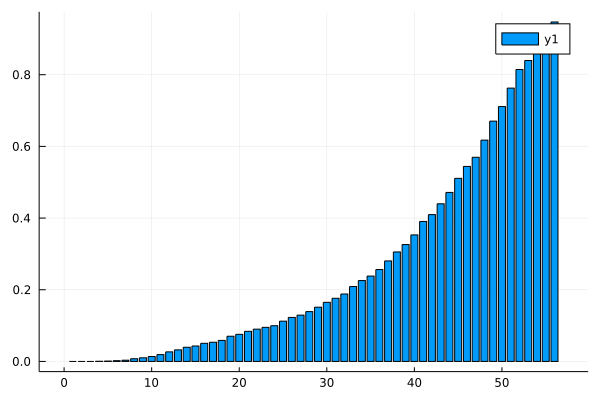

In [44]:
plot(stats[!, :cutoff], st=:bar)

Do the optimization. The demand for each school is a function of the preferability parameters and the total population, and the value of this function at each school must match the demand indicated in the input data.

In [45]:
function optimize(; N=1::Real)
    (m, ) = size(cutoff)
    p = vcat(cutoff, 1)

    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "hessian_approximation", "limited-memory")

    @variable(model, γ[1:m], lower_bound=0, upper_bound=1)
    total_pop = sum(demand)

    # Demand for each school must equal that predicted by MNL model.
    @NLconstraint(model, Demand[c in 1:m], 
                    total_pop * γ[c] * sum((p[d+1] - p[d]) / sum(γ[i] for i in 1:d) for d in c:m)
                    == demand[c])
    
    optimize!(model)
    
#     δ = log.(value.(γ))
    
    # Homogeneous in γ, so can make γ sum to any positive constant N
    return N .* value.(γ) ./ sum(value.(γ))
end

optimize (generic function with 1 method)

In [46]:
γ = optimize()

56-element Vector{Float64}:
 0.0002085351728195058
 0.0002171897946163628
 0.0006033507766951714
 0.0001266586458256833
 0.00020232254204793156
 0.0001395515368571677
 8.120400680796626e-5
 0.00030624077158633686
 0.0003498544211723188
 0.00015267860342642193
 4.243451547016321e-5
 0.0003127966176467813
 4.920347870189969e-5
 ⋮
 0.0030175126526839876
 0.010939778379151933
 0.0149252504658179
 0.00593248963319623
 0.028421309038674042
 0.014195621205796666
 0.05527793320079143
 0.1652725881110401
 0.051982334385478515
 0.031040327882995367
 0.0690995630483599
 0.4293805432248791

In [47]:
stats[!, :preferability] = γ;

Plot the preferability against cutoffs and capacities and see if there are any outliers.

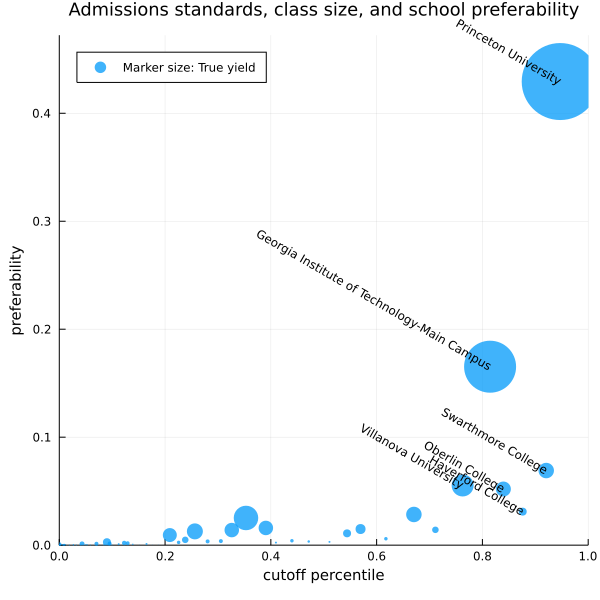

In [48]:
pl = plot(size=(600, 600), xlim=(0, 1), ylim=(0, 1.1*maximum(stats[!, :preferability])),
          xlabel="cutoff percentile", ylabel="preferability", labelfontsize=10, legend=:topleft,
          title="Admissions standards, class size, and school preferability", titlefontsize=12)

font = text("").font
font.rotation = -15
font.halign = :right
font.pointsize = 8

scatter!(pl,
         stats[!, :cutoff],
         stats[!, :preferability],
         marker=:circle,
         ms=stats[!, :trueyield]*100,
         msw=0,
         ma=.75,
         label="Marker size: True yield")

best = sortperm(stats[!, :preferability], rev=true)

for i in 1:6
    annotate!(pl,
          [(stats[best[i], :cutoff], 
            stats[best[i], :preferability],
            text(stats[best[i], :name], font))])
end

pl

In [49]:
savefig(pl, "plots/partial.png")
savefig(pl, "plots/partial.pdf")

## 2.2&emsp; Discussion

**N.B. The discussion below reflects a previous instance of this exercise which only considered SAT math scores; hence, the top schools were different. The essential interpretive principles hold, but the outcome under the updated model is much more realistic.**

What do you think? Does it look realistic? 

In general, the schools that top the list are popular overall. But it's surprising to see that, for example, UW Madison has a higher preferability rating than Princeton, which means (by the definition of the preference parameters) that a student admitted to both schools is slighly more likely to choose UW Madison.

This is an artifact of the design of the model, which considers only SAT math scores. UW Madison has unusually high math scores. Perhaps this is because most UW Madison applicants take the ACT (which is more popular in the Midwest) rather than the SAT; hence, the subset of admits who submitted the SAT are out-of-state students who are atypically zealous about their college search.

But for the sake of argument, let's take the results at face value and try to understand the economic relationship between cutoffs, demand, and what I am calling "true yield." In the model, Princeton's cutoff is 0.94, which means 6 percent or 5766 of the 96094 students in the market are able to get into Princeton. The number who chose to attend is 1285, for a true yield of 22 percent. 

On the other hand, UW Madison's cutoff is 0.81, so 19 percent of students can get into UW Madison, and of them 6279 choose to attend, for a true yield of 34 percent.

In [50]:
total_students = 96094
1285 /                        # Number of students who attend Princeton
    (0.06 * total_students)   # Number of students who could get into Princeton

0.2228720488965666

In [51]:
6279 /                        # Number of students who attend UW Madison
    (0.19 * total_students)   # Number of students who could get into UW Madison

0.34390667909601674

The inevitable conclusion, according to these results, is that UW Madison is more preferable overall. Consider it this way: UW Madison enrolls five times as many students as Princeton. And every student who is qualified for Princeton is also qualified for UW Madison. So, if every student who got into both schools chose Princeton, then UW Madison would have to *admit* six times as many students as Princeton to achieve this level of enrollment. But in reality, UW Madison admits about three times as many students as Princeton. This can only be explained by the fact that some (in fact, a plurality of) students who get into both schools choose UW Madison—again, according to this very limited model, which greatly underestimates Princeton's score cutoff. 

### True yield

The phrase "true yield" appears in scare quotes above because I am using it with a somewhat special meaning. Admissions officials use "yield" to refer to the percentage of *admitted applicants* who choose to attend the school. This is a function of three variables: the school's cutoff, the school's preferability, and the percentage of students who choose to apply.

True yield is the percentage of *qualified students* who choose to attend the school, and it is a function of only the school's preferability and cutoff. In reality, some students who will not attend a given college because they are uninterested or unqualified remove themselves from the applicant pool altogether; this phenomenon artificially inflates yield.

The common misuse of yield in college rankings as an indication of preferability has given rise to urban legends about <a href="https://en.wikipedia.org/wiki/Yield_protection">yield protection</a>, the idea that some middling colleges try to pad their yield statistics by rejecting highly-qualified applicants whom they expect to attend a better school.

Notice that the best predictor of preferability is true yield, and vice-versa (Pearson's $r = 0.95$). However, I argue that even true yield is a misleading indicator of school preferability, because it doesn't account for the fact that students at the upper end of the distribution have more choices. A student qualified for Princeton can choose from many schools, so the fact that 22.29 percent of them choose Princeton is more impressive than the fact that many students choose a given low-ranked university, since some of those students have no other choices to begin with. The preferability measure $\gamma$ is free of this bias.

In [52]:
cor(Array(stats[!, [:demand, :cutoff, :trueyield, :preferability]]))

4×4 Matrix{Float64}:
 1.0       0.214681  0.506677  0.181517
 0.214681  1.0       0.637343  0.562868
 0.506677  0.637343  1.0       0.925946
 0.181517  0.562868  0.925946  1.0

## 2.3 &emsp; Explicit solution

The system we are trying to solve is

$$\sum_{d=c}^{|C|} 
\frac{\gamma_c}{ \sum_{i=1}^d \gamma_i} 
\left(p_{d+1} - p_{d}\right)
=D_c, \quad \forall c \in C$$

Since this system is homogeneous in $\gamma$, we may assume without loss of generality that $\sum_{c=1}^{|C|} \gamma_c = N$, where $N$ is a constant. Then consider the demand for $|C|$, the school with the highest index and therefore highest cutoff. Students who get into this school necessarily get into every school, so the outer sum of the equation above has only one term, and the equation above becomes

$$D_{|C|} =
\frac{\gamma_{|C|}}{ \sum_{i=1}^{|C|} \gamma_i} 
\left(1 - p_{|C|}\right) \\
\implies \gamma_{|C|} = N \cdot \frac{D_{|C|}}{1 - p_{|C|}}
$$

Now suppose that $\gamma_{c+1}, \gamma_{c+2}, \dots, \gamma_{|C|}$ are known. Then $\gamma_c$ can also be calculated from the observation that $$\sum_{i=1}^d \gamma_i = N - \sum_{j=d+1}^{|C|} \gamma_j$$
where we take $\sum_{j=|C|+1}^{|C|} \gamma_j \equiv 0$.

Hence, the following recursive relation allows us to compute all the $\gamma_c$ values in reverse order, starting with $\gamma_{|C|}$ and moving down:
$$\begin{align}
\gamma_{|C|} &= N\cdot \frac{D_{|C|}}{1 - p_{|C|}} \\
\gamma_c &= \frac{D_c}{\sum_{d=c}^{|C|} \frac{p_{d+1} - p_d}{N - \sum_{j=d+1}^{|C|} \gamma_j} }, \quad \forall c \in \lbrace 1, \dots, |C|-1\rbrace
\end{align}$$
This expression is not very numerically stable. I present two implementations, one based on the formulation above, and another that attempts to mitigate numerical accuracy by working with $\sigma = \log_2 \gamma$. In both cases, we need extra wrappers on the denominator of the recursive rule to prevent division by zero and negative arguments to the logarithm. Even so, I was unable to recover the precision of the numerical formulation at the low end either by using the $\log_2$ formulation or by playing with the value of $N$.

In [53]:
function explicit_soln_γ(; N = 1::Real)
    (m, ) = size(cutoff)
    p = vcat(cutoff, 1)

    γ_expl = zeros(m)

    γ_expl[m] = N * demand[m] / (1 - p[m])

    for c in (m-1):-1:1
        denom = sum(p[d+1] > p[d] ? (p[d+1] - p[d]) * total_students /
                                    (d < m ? max(0, N * total_students - sum(γ_expl[j] for j in (d+1):m))
                                           : N * total_students)
                                  : 0
                    for d in c:m)
    #     @show denom
        γ_expl[c] = demand[c] / denom
    end

    return γ_expl ./ total_students
end

explicit_soln_γ (generic function with 1 method)

In [54]:
function explicit_soln_σ(; N = 1::Real)
    (m, ) = size(cutoff)
    p = vcat(cutoff, 1)
    σ = zeros(m)

    σ[m] = log2(N) + log2(demand[m]) - log2(1 - p[m])

    for c in (m-1):-1:1
        σ[c] = log2(demand[c]) -
               log2(sum(p[d+1] > p[d] ? (p[d+1] - p[d]) * total_students /
                                        (d < m ? max(0, N * total_students - sum(2 ^ σ[j] for j in (d+1):m))
                                               : N * total_students)
                                      : 0
                         for d in c:m))
    end

    return σ .- log2(total_students)
end

explicit_soln_σ (generic function with 1 method)

Here is a comparison of the three results. Because of the rounding, the lowest-ranked schools have their preferability clipped to zero. However, the values for the higher-ranked schools are more accurate using the explicit formulation. Notice that Princeton's preferability must match its true yield of 22.29 percent, because students who get into Princeton also get into all the other schools. The explicit formulation correctly determines this.

**The improved method of estimating the cutoffs removes "tied" cutoffs, which greatly improves the numerical accuracy.**

In [55]:
total_students = sum(stats[!, :demand])

hcat(γ, explicit_soln_γ(), 2 .^ explicit_soln_σ())#[rand(1:length(γ), 10), :]

56×3 Matrix{Float64}:
 0.000208535  0.000208535  0.000208535
 0.00021719   0.00021719   0.00021719
 0.000603351  0.000603351  0.000603351
 0.000126659  0.000126659  0.000126659
 0.000202323  0.000202323  0.000202323
 0.000139552  0.000139552  0.000139552
 8.1204e-5    8.1204e-5    8.1204e-5
 0.000306241  0.000306241  0.000306241
 0.000349854  0.000349854  0.000349854
 0.000152679  0.000152679  0.000152679
 4.24345e-5   4.24345e-5   4.24345e-5
 0.000312797  0.000312797  0.000312797
 4.92035e-5   4.92035e-5   4.92035e-5
 ⋮                         
 0.00301751   0.00301751   0.00301751
 0.0109398    0.0109398    0.0109398
 0.0149253    0.0149253    0.0149253
 0.00593249   0.00593249   0.00593249
 0.0284213    0.0284213    0.0284213
 0.0141956    0.0141956    0.0141956
 0.0552779    0.0552779    0.0552779
 0.165273     0.165273     0.165273
 0.0519823    0.0519823    0.0519823
 0.0310403    0.0310403    0.0310403
 0.0690996    0.0690996    0.0690996
 0.429381     0.429381     0.429381

In [56]:
sum(ans, dims=1)

1×3 Matrix{Float64}:
 1.0  1.0  1.0

In [57]:
demand[end] / (1 - cutoff[end])

24289.19856914496

The tractability of this new formulation will let us rank all 1182 schools.

In [58]:
stats = DataFrame(CSV.File("admitstats.csv"))

# Sort by cutoff to make admissions sets nested
sort!(stats, :cutoff)
total_students = sum(stats[!, :demand])

# See discussion below
stats[!, :trueyield] = stats[!, :demand] ./ ((1 .- stats[!, :cutoff]) .* total_students)  

demand = stats[!, :demand]
cutoff = stats[!, :cutoff]

stats[!, :preferability] = explicit_soln_γ()

# Exactly the same
# stats[!, :preferability2] = 2 .^ explicit_soln_σ()

display(first(stats, 5))
display(last(stats, 5))

,name,demand,cutoff,trueyield,preferability
,String,Int64,Float64,Float64,Float64
1,University of Arkansas at Pine Bluff,568,0.0,0.000754329,6.27665e-6
2,Delaware State University,1036,0.0,0.00137585,1.14482e-5
3,Wesley College,556,0.0,0.000738393,6.14404e-6
4,Edward Waters College,208,0.0,0.000276233,2.29849e-6
5,St Thomas University,210,0.0,0.000278889,2.32059e-6


,name,demand,cutoff,trueyield,preferability
,String,Int64,Float64,Float64,Float64
1,Massachusetts Institute of Technology,1115,0.949992,0.0296105,0.0293106
2,University of Chicago,1426,0.950115,0.0379629,0.0375916
3,Harvard University,1659,0.95433,0.0482426,0.0481942
4,Yale University,1356,0.954392,0.0394846,0.0394476
5,California Institute of Technology,249,0.959583,0.00818176,0.00818176


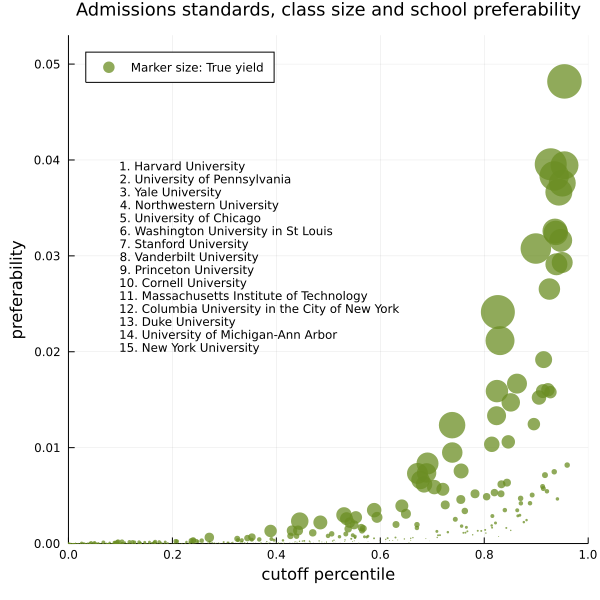

In [85]:
pl = plot(size=(600, 600), xlim=(0, 1), ylim=(0, 1.1*maximum(stats[!, :preferability])),
          xlabel="cutoff percentile", ylabel="preferability", legend=:topleft,
          title="Admissions standards, class size and school preferability", titlefontsize=12)

scatter!(pl,
         stats[!, :cutoff],
         stats[!, :preferability],
         marker=:circle,
         ms=stats[!, :trueyield]*400,
         msw=0,
         ma=.75,
         color=:olivedrab,
         label="Marker size: True yield")

font = text("").font
font.rotation = 0
font.halign = :left
font.valign = :top
font.pointsize = 8

best = sortperm(stats[!, :preferability], rev=true)

# for i in 1:15
#     annotate!(pl,
#           [(stats[best[i], :cutoff], 
#             stats[best[i], :preferability],
#             text(stats[best[i], :name], font))])
# end

annotate!(pl, [(0.1, 0.04, text(join([string(i)*". "*stats[best[i], :name] for i in 1:15], '\n'), font))])

pl

In [88]:
stats[best[end], :]

,name,demand,cutoff,trueyield,preferability
,String,Int64,Float64,Float64,Float64
39,College of St Joseph,33,0.0,4.38255e-5,3.64664e-7


In [89]:
savefig(pl, "plots/full.png")
savefig(pl, "plots/full.pdf")